In [269]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from decimal import Decimal

# %pip install openpyxl

As I will need to keep all the decimal digits for APR calculations later on, I will display just 5 decimals for visibility, but will work with all decimals available for APR.

In [270]:
# Displaying options:
pd.set_option('display.float_format', '{:.5f}'.format)

In [271]:

# Reading the excel file

source_path = Path('/Users/arortega/Desktop/git/world_bank_etl/test_pwc/data_source/pwc_bank_data.csv')

df = (
    pd.read_csv(
        source_path,
        encoding='utf-16'
    )
)

# Dropping the first empty column which came from the Excel export

df = (
    df
    .drop(
        columns=df.columns[0]
    )
)

df.head()



,CustomerID,Name,Address,Phone,Phone_2,Email,DateJoined,AccountID,BranchID,AccountType,...,TransactionID,Date,Type,Amount,Fee,BranchName,ManagerID,EmployeeID,Position,DateHired
0,1.00000,Allison Hill,"819 Johnson Course,East William, AK 74064",886.737.9402,223-951-1615x594,dudleynicholas@example.net,2013-11-30,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.00000,Lisa Hensley,"34131 Ramirez Roads,Franciscostad, IL 88342",719-228-3276x483,505.964.1395,pwilkerson@example.com,2008-10-19,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.00000,David Hoffman,"653 William Course Apt. 122,Carlsonfurt, MS 78605",484.980.1845x146,5484281489,kathryn88@example.org,2014-12-20,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.00000,Brian Cox DVM,"39117 Tiffany Place,East Donna, OH 22144",989-363-8346x578,531.250.9839,zimmermanbrian@example.org,2005-01-03,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.00000,Andrea Young,"299 Sanchez Mountains,Leeville, TN 56999",(566)970-1065x133,(362)247-3178,novaksara@example.org,2009-08-06,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can see several things to fix. For example:
- The date fields shall be cast to datetype
- There are missing values everyowhere which need further investigation
- ID fields are floats instead of integers
- Balance columns is object type, which needs to be fixed since it should be flaot.

In [272]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3398 entries, 0 to 3397
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustomerID     250 non-null    float64
 1   Name           164 non-null    object 
 2   Address        108 non-null    object 
 3   Phone          147 non-null    object 
 4   Phone_2        80 non-null     object 
 5   Email          164 non-null    object 
 6   DateJoined     100 non-null    object 
 7   AccountID      3226 non-null   float64
 8   BranchID       222 non-null    float64
 9   AccountType    150 non-null    object 
 10  DateOpened     150 non-null    object 
 11  Balance        150 non-null    object 
 12  APR            150 non-null    object 
 13  TransactionID  3076 non-null   float64
 14  Date           3076 non-null   object 
 15  Type           3076 non-null   object 
 16  Amount         3076 non-null   object 
 17  Fee            3076 non-null   float64
 18  BranchNa

## 0. Initial EDA (final EDA performed after modeling)

As I discovered during EDA, columns 'Phone' and 'Phone_2' have missing values. In order for my functions to work properly managing nulls, I will fill the na's with the string 'No Phone' for the missing phones. This should not disturb the data, since phones are not primary or secondary keys anywhere.

In [273]:
df['Phone'] = df['Phone'].fillna('missing_phone_1')
df['Phone_2'] = df['Phone_2'].fillna('missing_phone_2')

I will now cast all columns accordingly.

In [274]:
df['DateJoined'] = pd.to_datetime(
    df['DateJoined']
    , errors='coerce'
)

df['DateOpened'] = pd.to_datetime(
    df['DateOpened']
    , errors='coerce'
)

df['Date'] = pd.to_datetime(
    df['Date']
    , errors='coerce'
)

df['DateHired'] = pd.to_datetime(
    df['DateHired']
    , errors='coerce'
)


For some reason during the export, the ID columns were cast as flaots and when cast into integers, they remove the last digit. We will cast them as integers and add a 0 (or multiply by 10) to match the original csv.

In [275]:
df['CustomerID'] = df['CustomerID'].astype('Int64') * 10
df['AccountID'] = df['AccountID'].astype('Int64') * 10
df['BranchID'] = df['BranchID'].astype('Int64') * 10
df['TransactionID'] = df['TransactionID'].astype('Int64') * 10
df['ManagerID'] = df['ManagerID'].astype('Int64') * 10
df['EmployeeID'] = df['EmployeeID'].astype('Int64') * 10



## 1. Data modeling

The file contains 5 different tables (entities) combined in the same one. First, we need to separate and save the 5 different entities in 3 different tables (dataframes) and stablish their relationships, meaning Primary and Foreign keys.

The main entities are:
- Customers
- Branches
- Employees
- Accounts
- Transactions

I figured the data model by checking which columns are filled for the different values. I attach a descriptive image of the RDB model with the respective relationships.

In [276]:
# Let's instantiate the data model's columns dictionary

data_model_columns = {
    'customers': [
        'CustomerID', 'Name', 'Address', 'Phone', 
        'Phone_2', 'Email', 'DateJoined'
    ],
    'branches': [
        'BranchID', 'BranchName', 'Address', 'ManagerID',
    ],
    'employees': [
        'EmployeeID', 'BranchID', 'Position', 'DateHired', 
        'Name', 'Phone', 'Email'
    ],
    'accounts': [
        'AccountID', 'BranchID', 'AccountType',
        'Balance', 'DateOpened', 'APR', 'CustomerID'
    ],
    'transactions': [
        'TransactionID', 'AccountID', 'Amount', 'Date', 'Type', 'Fee'
    ]
}



I will write a helper function that will split the main df in different tables, based on the data model and the missing/filled values:

In [277]:
def split_tables(df, data_model_columns):
    tables = {}
    for table_name, columns in data_model_columns.items():
        # Just the columns existing in the df
        valid_cols = [col for col in columns if col in df.columns]

        if not valid_cols:
            continue  # if no columns exist, skip

        # Create a boolean mask where all columns must have data (notnull)
        mask = df[valid_cols].notnull().all(axis=1)

        # Filter rows + keep only those columns
        tables[table_name] = df.loc[mask, valid_cols]

    return tables

tables = split_tables(df, data_model_columns)

customers = tables['customers']
branches = tables['branches']
employees = tables['employees']
accounts = tables['accounts']
transactions = tables['transactions']



Lastly, we will rename the ambiguious columns to avoid confussions. I will write a small helper function for that as well:

In [278]:
# The tables in the entity list are the only ones with confusing column names
entity_list = ['customers', 'branches', 'employees']

def rename_columns(df, entity):
    df = df.rename(columns={
        'Name': f'{entity}_name',
        'Phone': f'{entity}_phone',
        'Email': f'{entity}_email',
        'Address': f'{entity}_address'
    })

    return df

customers = rename_columns(customers, 'customers')
branches = rename_columns(branches, 'branches')
employees = rename_columns(employees, 'employees')



## 2. Final EDA

I will split and clean the 'Balance' column in accounts_df, into 2 different columns:
- Amount
- Currency

This way would be much easier and consistent to overview the products and balance

In [279]:
accounts['Currency'] = (
    accounts['Balance']
    .str.extract(r'([A-Z]+)$')
)

accounts['balance_flat'] = (
    accounts['Balance']
    .str.extract(r'([0-9.eE+-]+)')
)

accounts['balance_flat'] = (
    accounts['balance_flat']
    .astype(float)
)

accounts['balance_flat'] = (
    accounts['balance_flat']
    .round(2)
)



'Amount' from Transactions came with commas (,) instead of decimal points, so I will replace them and then cast 'Amount' as flaot for final EDA:

In [280]:
transactions['Amount'] = transactions['Amount'].str.replace('[$,]', '.', regex=True)
transactions['Amount'] = transactions['Amount'].astype(float)

And finally, 'APR' from accounts comes as strings, with decimal commas instead of points and scientific notation. We will leave all decimals and cast it as Decimal to conserve all 0's.

In [281]:
accounts['APR'] = accounts['APR'].str.replace(',', '.', regex=False)
accounts['APR'] = accounts['APR'].apply(Decimal)

___

## 3. Main Questions

### 3.1. Overview of available banking products and their current volume

In [282]:
accounts.groupby('AccountType').size()

AccountType
Current    45
Loan       50
Saving     55
dtype: int64

Calculate APR and Fees by account type

In [283]:
transactions_accounts = (
    transactions
    .merge(
        accounts
        , on='AccountID'
        , how='right'
    )
)

volumne_balance_per_product = (
    transactions_accounts
    .groupby(
        ['AccountType', 'Currency']
    )
    .agg(
        transaction_count = ('TransactionID', 'count')
        , balance_sum = ('balance_flat', 'sum')
        , balance_mean = ('balance_flat', 'mean')
        , balance_median = ('balance_flat', 'median')
        , balance_std = ('balance_flat', 'std')
        , balance_min = ('balance_flat', 'min')
        , balance_max = ('balance_flat', 'max')
    )
)

volumne_balance_per_product

,,transaction_count,balance_sum,balance_mean,balance_median,balance_std,balance_min,balance_max
AccountType,Currency,,,,,,,
Current,CZK,1360,71933908.70000,52892.57993,54219.50000,28684.07055,782.31000,94606.20000
Loan,EUR,0,33907383.70000,678147.67400,740550.00000,358874.84549,29580.50000,1220260.00000
Saving,CZK,1716,3322686465.40000,1936297.47401,1942560.00000,1121071.97304,12981.20000,3887550.00000


In [284]:
display(
    transactions_accounts
    .groupby(
        'Type'
    )
    .agg(
        {
            'Amount' : 'mean'
        }
    )
)

,Amount
Type,
Bonus,500.00000
Deposit,3877.53047
Transfer,1467.38338
Withdrawal,1504.68054


In [285]:
# Transactions table doesn't have currency information, just the amount. I need to see if each account can only
# have one type of currency or multiple types.

display(
    transactions_accounts
    .groupby(
        ['AccountID', 'Currency']
    )
    .agg(
        currency_count = ('Currency', 'nunique')
    )
)

,,currency_count
AccountID,Currency,
10,CZK,1
20,CZK,1
30,EUR,1
40,CZK,1
50,CZK,1
...,...,...
1460,CZK,1
1470,EUR,1
1480,CZK,1


In [286]:
# There's a total of 150 unique accounts, and each accounts has only one Currency type, meaning transactions on each account
# respective currency correspond to the account's currency.

accounts['AccountID'].nunique()


150

In [287]:
# Furthermore, the only accounts in EUR are the savings accounts, for some reason. Rest of account types are in CZK.

accounts_test = accounts.copy()
accounts_test = accounts_test[accounts_test['AccountType'] == 'Loan']

display(
    accounts_test
    .groupby(
        ['AccountType', 'Currency']
    )
    .agg(
        unique_values = ('AccountID', 'nunique')
    )
)


,,unique_values
AccountType,Currency,
Loan,EUR,50


In [288]:
# There are no transactions for loan accounts, which means that we can study all transactions in CZK currency.

display(
    transactions_accounts
    .groupby(
        'AccountType'
    )
    .agg(
        unique_values = ('TransactionID', 'nunique')
    )
)

,unique_values
AccountType,
Current,1360
Loan,0
Saving,1716


### 3.2. Count and volume of transactions per product (Some transactions might be inconsistent)

In [289]:
count_vol_transactions = (
    transactions_accounts
    .groupby(
        ['AccountType', 'Type']
    )
    .agg(
        count = ('TransactionID', 'count'),
        transaction_mean = ('Amount', 'mean'),
        transaction_max = ('Amount', 'max'),
        transaction_min = ('Amount', 'min'),
        transaction_std = ('Amount', 'std')
    )
)

display(
    count_vol_transactions
)

# We found an outlier transaction, where a huge ammount was deposted on a savings account
# There are no withdrawals nor transfers from the savings accounts

count  transaction_mean  transaction_max  \
AccountType Type                                                   
Current     Deposit       463        1450.35458       2991.83000   
            Transfer      455        1467.38338       2996.97000   
            Withdrawal    442        1504.68054       2992.39000   
Saving      Bonus          51         500.00000        500.00000   
            Deposit      1665        4552.47488    3520663.57000   

                        transaction_min  transaction_std  
AccountType Type                                          
Current     Deposit            12.52000        872.56783  
            Transfer           13.01000        857.69133  
            Withdrawal         15.85000        855.23263  
Saving      Bonus             500.00000          0.00000  
            Deposit            10.51000      90300.00460

In [290]:
# We will use the inter quartile range to identify outliers
Q1 = transactions_accounts['Amount'].quantile(0.25)
Q3 = transactions_accounts['Amount'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = transactions_accounts[
    (transactions_accounts['Amount'] < lower_bound) |
    (transactions_accounts['Amount'] > upper_bound)
]

display(outliers)



,TransactionID,AccountID,Amount,Date,Type,Fee,BranchID,AccountType,Balance,DateOpened,APR,CustomerID,Currency,balance_flat
25,29950,10,10250.66000,2023-05-21,Deposit,50.00000,50,Saving,12981.2 CZK,2023-05-21,0.050000000000000003,930,CZK,12981.20000
1006,30260,510,3520663.57000,2023-07-27,Deposit,50.00000,20,Saving,3.52346e+006 CZK,2023-07-27,0.059999999999999998,480,CZK,3523460.00000
1035,30210,520,631037.20000,2023-07-15,Deposit,50.00000,70,Saving,630987 CZK,2023-07-15,0.059999999999999998,910,CZK,630987.00000
2845,29630,1360,896938.80000,2023-02-17,Deposit,50.00000,80,Saving,896889 CZK,2023-02-17,0.01,840,CZK,896889.00000


We can observe there are 4 main outliers in the data, which correspond to big deposits made in savings accounts, and skew the deposit ammount mean. To better understand transactions nature, we will eliminate them from the df, since they don't really add any value to our study.

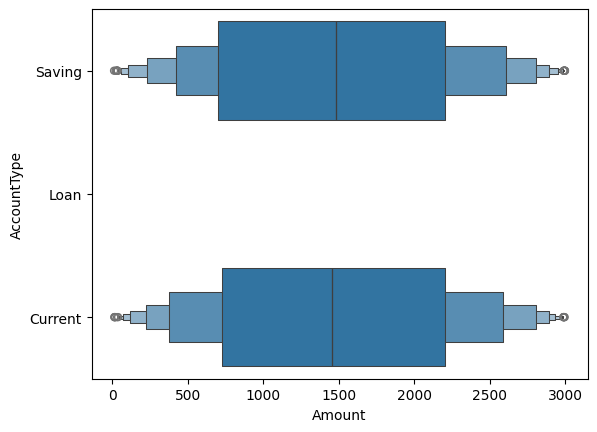

In [291]:
outliers_ID_list = outliers['TransactionID'].tolist()

# We will remove the outliers from the dataset
transactions_accounts_clean = transactions_accounts[
    ~transactions_accounts['TransactionID'].isin(outliers_ID_list)
]

sns.boxenplot(
    data=transactions_accounts_clean,
    x='Amount',
    y='AccountType'
)

plt.show()



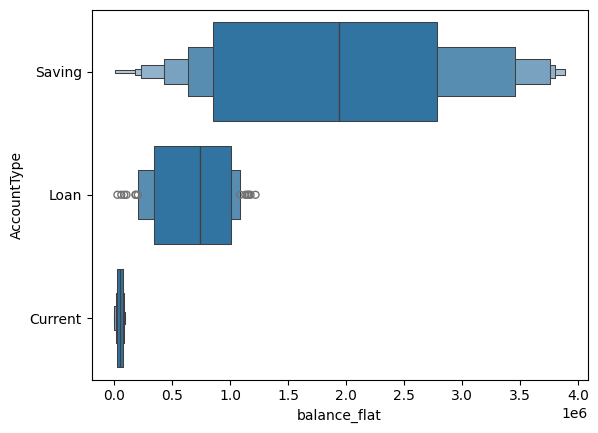

In [292]:
sns.boxenplot(
    data=transactions_accounts,
    x='balance_flat',
    y='AccountType'
)
plt.show()

In [293]:
display(
    transactions_accounts[
        (transactions_accounts['AccountType'] == 'Loan')
        & (transactions_accounts['TransactionID'].notnull())
    ]
)

# Loan accounts don't have transactions since the money is desposited there the same day the account is opened, which is
# not considered a transaction type 'Deposit', perhaps this could be improved in the future.

,TransactionID,AccountID,Amount,Date,Type,Fee,BranchID,AccountType,Balance,DateOpened,APR,CustomerID,Currency,balance_flat


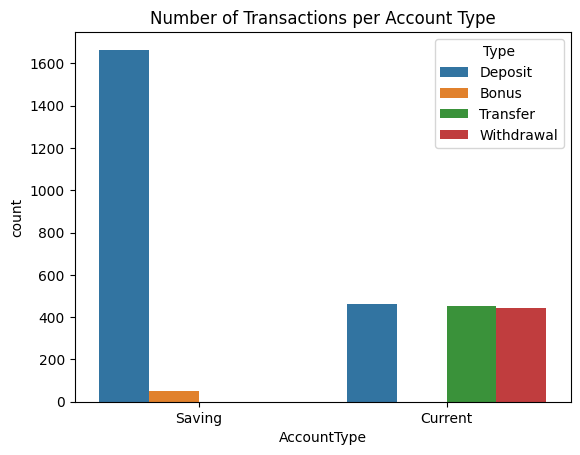

In [294]:
# Bar chart with number of transactions per account type (removing loan since there are no transactions)
sns.countplot(
    data=(
        transactions_accounts[
            transactions_accounts['AccountType'] != 'Loan'
        ]
    )
    , x='AccountType', hue='Type'
)

plt.title('Number of Transactions per Account Type')
plt.show()


### 3.3. Overview of the costs and revenues per product in the last year (2023) together with product profitability
You should consider the interest rates (loans and savings) and transaction fees (current account and savings) for the
calculation.

In [295]:
display(
    accounts
    .groupby(
        'AccountType'
    )
    .agg(
        mean_APR=('APR', 'mean')
    )
)

,mean_APR
AccountType,
Current,0.00000
Loan,0.08700
Saving,0.04236
